In [1]:
library("lme4")
library("ggplot2")
library("dplyr")
library(MASS)
library("BayesFactor")
library("car")
library("scales")
library("lmerTest")
library("MuMIn")
library("plyr")
library("knitr")
library("rstatix")
library("ggpubr")
library("RColorBrewer")

Loading required package: Matrix


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union



Attaching package: ‘MASS’


The following object is masked from ‘package:dplyr’:

    select


Loading required package: coda

************
Welcome to BayesFactor 0.9.12-4.2. If you have questions, please contact Richard Morey (richarddmorey@gmail.com).

Type BFManual() to open the manual.
************

Loading required package: carData

Registered S3 methods overwritten by 'car':
  method                          from
  influence.merMod                lme4
  cooks.distance.influence.merMod lme4
  dfbeta.influence.merMod         lme4
  dfbetas.influence.merMod        lme4


Attaching package: ‘car’


The following object is masked from ‘package:dplyr’:

    recode



Attaching package: ‘lmerTest’


The following object is masked from ‘package:lme4’:

   

In [2]:
#Load the data => Here, we are filtering the cases in which subjects had a MuIFI of 0
FinalPath<-'../ToInput/R_HumMod_MS17_notemp.txt'
data <- read.delim(FinalPath, sep="\t", header=T, stringsAsFactors=F)
data <- data %>% filter(!Amplitude==0) 
dataTest <- data
data$lCV <- log(data$CV)

In [3]:
##Source for "SummarySE": http://www.cookbook-r.com/Manipulating_data/Summarizing_data/
##
##
## Gives count, mean, standard deviation, standard error of the mean, and confidence interval (default 95%).
##   data: a data frame.
##   measurevar: the name of a column that contains the variable to be summariezed
##   groupvars: a vector containing names of columns that contain grouping variables
##   na.rm: a boolean that indicates whether to ignore NA's
##   conf.interval: the percent range of the confidence interval (default is 95%)
summarySE <- function(data=NULL, measurevar, groupvars=NULL, na.rm=FALSE,
                      conf.interval=.95, .drop=TRUE) {
    library(plyr)

    # New version of length which can handle NA's: if na.rm==T, don't count them
    length2 <- function (x, na.rm=FALSE) {
        if (na.rm) sum(!is.na(x))
        else       length(x)
    }

    # This does the summary. For each group's data frame, return a vector with
    # N, mean, and sd
    datac <- ddply(data, groupvars, .drop=.drop,
      .fun = function(xx, col) {
        c(N    = length2(xx[[col]], na.rm=na.rm),
          mean = mean   (xx[[col]], na.rm=na.rm),
          sd   = sd     (xx[[col]], na.rm=na.rm)
        )
      },
      measurevar
    )

    # Rename the "mean" column    
    datac <- rename(datac, c("mean" = measurevar))

    datac$se <- datac$sd / sqrt(datac$N)  # Calculate standard error of the mean

    # Confidence interval multiplier for standard error
    # Calculate t-statistic for confidence interval: 
    # e.g., if conf.interval is .95, use .975 (above/below), and use df=N-1
    ciMult <- qt(conf.interval/2 + .5, datac$N-1)
    datac$ci <- datac$se * ciMult

    return(datac)
}

In [4]:
# Multiple plot function: source: http://www.cookbook-r.com/Graphs/Multiple_graphs_on_one_page_(ggplot2)/
#
#
# ggplot objects can be passed in ..., or to plotlist (as a list of ggplot objects)
# - cols:   Number of columns in layout
# - layout: A matrix specifying the layout. If present, 'cols' is ignored.
#
# If the layout is something like matrix(c(1,2,3,3), nrow=2, byrow=TRUE),
# then plot 1 will go in the upper left, 2 will go in the upper right, and
# 3 will go all the way across the bottom.
#
multiplot <- function(..., plotlist=NULL, file, cols=1, layout=NULL) {
  library(grid)

  # Make a list from the ... arguments and plotlist
  plots <- c(list(...), plotlist)

  numPlots = length(plots)

  # If layout is NULL, then use 'cols' to determine layout
  if (is.null(layout)) {
    # Make the panel
    # ncol: Number of columns of plots
    # nrow: Number of rows needed, calculated from # of cols
    layout <- matrix(seq(1, cols * ceiling(numPlots/cols)),
                    ncol = cols, nrow = ceiling(numPlots/cols))
  }

 if (numPlots==1) {
    print(plots[[1]])

  } else {
    # Set up the page
    grid.newpage()
    pushViewport(viewport(layout = grid.layout(nrow(layout), ncol(layout))))

    # Make each plot, in the correct location
    for (i in 1:numPlots) {
      # Get the i,j matrix positions of the regions that contain this subplot
      matchidx <- as.data.frame(which(layout == i, arr.ind = TRUE))

      print(plots[[i]], vp = viewport(layout.pos.row = matchidx$row,
                                      layout.pos.col = matchidx$col))
    }
  }
}

In [5]:
table(data$GameSpeed, data$Temperature)

     
      Human   no  yes
  MMM   273 1499 1499
  MSM   286 1490 1491
  SMS   282 1495 1498
  SSS   273 1499 1496

# Extract First 5 games data

In [6]:
#Getting means for games 1-5
Data1_5 <- data %>% filter(Agent=="Human")
n_games <- 15
for(i in 6:15){
    Data1_5 <- Data1_5 %>% filter(GameNb!=i)
}
table(Data1_5$Agent, Data1_5$GameSpeed)

DataM1_5 <- ddply(Data1_5, c("Subject","Agent","GameSpeed"), summarize,  Amplitude=mean(Amplitude),Periodicity=mean(Periodicity),Entropy=mean(Entropy),lCV=mean(lCV))
DataM1_5 <- DataM1_5[order(DataM1_5$Subject),]
nb_subjs1<-nrow(DataM1_5)
nb_subjs1
#nrow(DataM1_5)
head(DataM1_5,10)

       
        MMM MSM SMS SSS
  Human  80  92  95  84

[1] 77

,Subject,Agent,GameSpeed,Amplitude,Periodicity,Entropy,lCV
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,A10GBO6PU2EI0K,Human,MSM,0.19151277,784.0,3.246518,-1.2202040
2,A12WDL4PB927P6,Human,SMS,0.14389429,1084.8,3.589319,-0.7473337
3,A12ZO39VZ879ZS,Human,SMS,0.11915947,1180.8,3.394718,-1.2443726
4,A15J42M6EC7Y1K,Human,SSS,0.07435005,1193.6,3.665702,-1.2107393
5,A16335MOISDG1F,Human,MSM,0.14269687,640.0,3.172987,-0.9372757
6,A19M1TGTL9HKHB,Human,SSS,0.12906968,1305.6,3.491844,-1.0682865
7,A1AJ2G7JXXJ8UJ,Human,MMM,0.15628601,726.4,3.160044,-1.1044700
8,A1E8ZYOQSGKTP8,Human,MSM,0.38543002,992.0,3.398248,-0.2857093
9,A1EQAFAN71Z0SK,Human,SSS,0.18445878,1260.8,3.633584,-1.2598311


# Extract Middle 5 games data

In [7]:
#Getting means for games 6-10
Data6_10 <- data %>% filter(Agent=="Human")
n_games <- 15
for(i in 1:5){
    Data6_10 <- Data6_10 %>% filter(GameNb!=i)
}
for(i in 11:15){
    Data6_10 <- Data6_10 %>% filter(GameNb!=i)
}
table(Data6_10$Agent, Data6_10$GameSpeed)

DataM6_10 <- ddply(Data6_10, c("Subject","Agent","GameSpeed"), summarize,  Amplitude=mean(Amplitude),Periodicity=mean(Periodicity),Entropy=mean(Entropy),lCV=mean(lCV))
DataM6_10 <- DataM6_10[order(DataM6_10$Subject),]
nb_subjs<-nrow(DataM6_10)
nb_subjs
head(DataM6_10,10)

       
        MMM MSM SMS SSS
  Human  95  97  90  93

[1] 78

,Subject,Agent,GameSpeed,Amplitude,Periodicity,Entropy,lCV
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
1,A10GBO6PU2EI0K,Human,MSM,0.06550943,1219.2,3.332735,-1.3783059
2,A12WDL4PB927P6,Human,SMS,0.19825693,904.0,3.086130,-0.7575121
3,A12ZO39VZ879ZS,Human,SMS,0.23277921,748.8,3.018638,-1.3199233
4,A15J42M6EC7Y1K,Human,SSS,0.09187504,1347.2,3.581618,-1.2493415
5,A16335MOISDG1F,Human,MSM,0.20426644,1267.2,3.402664,-1.5323308
6,A19M1TGTL9HKHB,Human,SSS,0.10614098,1456.0,3.373728,-1.2621086
7,A1AJ2G7JXXJ8UJ,Human,MMM,0.12836712,739.2,2.964896,-1.3636945
8,A1E8ZYOQSGKTP8,Human,MSM,0.23646547,1331.2,3.745417,-0.5282842
9,A1EQAFAN71Z0SK,Human,SSS,0.26503487,1212.8,3.296914,-1.3491235


In [8]:
#One way
for(aa in 1:nb_subjs){
    cur_Subject <- DataM6_10$Subject[aa]
    if(!(cur_Subject %in% DataM1_5$Subject)){
        DataM6_10 <- DataM6_10[-aa,]
    }
}
nb_Ags2<-nrow(DataM6_10)
nb_Ags2
#Second way
for(aa in 1:nb_subjs1){
    cur_Subject <- DataM1_5$Subject[aa]
    if(!(cur_Subject %in% DataM6_10$Subject)){
        DataM1_5 <- DataM1_5[-aa,]
    }
}
nb_Ags1<-nrow(DataM1_5)
nb_Ags1


#filter slow and medium
Start_Slow <- DataM1_5 %>% filter(!GameSpeed=='MMM') %>% filter(!GameSpeed=='MSM') %>% filter(!GameSpeed=='SMS')
Start_Medium <- DataM1_5 %>% filter(!GameSpeed=='SSS') %>% filter(!GameSpeed=='SMS') %>% filter(!GameSpeed=='MSM')
Start_SlowT <- DataM1_5 %>% filter(!GameSpeed=='MMM') %>% filter(!GameSpeed=='MSM') %>% filter(!GameSpeed=='SSS')
Start_MediumT <- DataM1_5 %>% filter(!GameSpeed=='SSS') %>% filter(!GameSpeed=='SMS') %>% filter(!GameSpeed=='MMM')

#filter slow and medium
Mid_MSM <- DataM6_10 %>% filter(GameSpeed=='MSM')
Mid_SMS <- DataM6_10 %>% filter(GameSpeed=='SMS')
Mid_MMM <- DataM6_10 %>% filter(GameSpeed=='MMM')
Mid_SSS <- DataM6_10 %>% filter(GameSpeed=='SSS')

[1] 76

[1] 76

In [9]:
require(nlme)
require(multcomp)

Loading required package: nlme


Attaching package: ‘nlme’


The following object is masked from ‘package:dplyr’:

    collapse


The following object is masked from ‘package:lme4’:

    lmList


Loading required package: multcomp

Loading required package: mvtnorm

Loading required package: survival

Loading required package: TH.data


Attaching package: ‘TH.data’


The following object is masked from ‘package:MASS’:

    geyser




# Periodicity

In [10]:
Hum_StMed <- Start_Medium$Periodicity
Ag_StMed <- Start_Medium$Subject
n1<-length(Hum_StMed)
n1
Hum_StSlow <- Start_Slow$Periodicity
Ag_StSlow <- Start_Slow$Subject
n2<-length(Hum_StSlow)
n2
Hum_StMedT <- Start_MediumT$Periodicity
Ag_StMedT <- Start_MediumT$Subject
n1b<-length(Hum_StMedT)
n1b
Hum_StSlowT <- Start_SlowT$Periodicity
Ag_StSlowT <- Start_SlowT$Subject
n2b<-length(Hum_StSlowT)
n2b
Hum_MidMed <- Mid_SMS$Periodicity
Ag_MidMed <- Mid_SMS$Subject
n3<-length(Hum_MidMed)
n3
Hum_MidSlow <- Mid_MSM$Periodicity
Ag_MidSlow <- Mid_MSM$Subject
n4<-length(Hum_MidSlow)
n4
Hum_MidPureM <- Mid_MMM$Periodicity
Ag_MidPureM <- Mid_MMM$Subject
n5<-length(Hum_MidPureM)
n5
Hum_MidPureS <- Mid_SSS$Periodicity
Ag_MidPureS <- Mid_SSS$Subject
n6<-length(Hum_MidPureS)
n6
n_Total<-n1+n2+n1b+n2b+n3+n4+n5+n6
n_Total

[1] 18

[1] 19

[1] 20

[1] 19

[1] 19

[1] 20

[1] 18

[1] 19

[1] 152

In [11]:
Speed <- c(rep("Medium",n1b),rep("Slow",n2b),rep("Medium",n1),rep("Slow",n2),rep("Medium",n3),rep("Slow",n4),rep("Medium",n5),rep("Slow",n6))
Subject <- c(Ag_StMedT,Ag_StSlowT,Ag_StMed,Ag_StSlow,Ag_MidMed,Ag_MidSlow,Ag_MidPureM,Ag_MidPureS)
Periodicity <- c(Hum_StMedT,Hum_StSlowT,Hum_StMed,Hum_StSlow,Hum_MidMed,Hum_MidSlow,Hum_MidPureM,Hum_MidPureS)
Phase <- c(rep("StartT",n1b),rep("StartT",n2b),rep("StartNoT",n1),rep("StartNoT",n2),rep("MidT",n3),rep("MidT",n4),rep("MidNoT",n5),rep("MidNoT",n6))
length(Speed)
ToPlot_Per <- data.frame(Subject,Speed,Phase,Periodicity)
ToPlot_Per$Speed <- ordered(ToPlot_Per$Speed, levels = c("Slow", "Medium"))
ToPlot_Per$Phase <- ordered(ToPlot_Per$Phase, levels = c("StartT", "StartNoT","MidT","MidNoT"))
#ToPlot_Per$Speed <- reorder(ToPlot_Per$Speed,desc(ToPlot_Per$Speed))
head(ToPlot_Per)

[1] 152

,Subject,Speed,Phase,Periodicity
,<fct>,<ord>,<ord>,<dbl>
1,A10GBO6PU2EI0K,Medium,StartT,784.0
2,A16335MOISDG1F,Medium,StartT,640.0
3,A1E8ZYOQSGKTP8,Medium,StartT,992.0
4,A1YSBD5XW5UCR0,Medium,StartT,636.8
5,A2E609OEGN4D6H,Medium,StartT,692.0
6,A2GO3SYV3X3KE,Medium,StartT,784.0


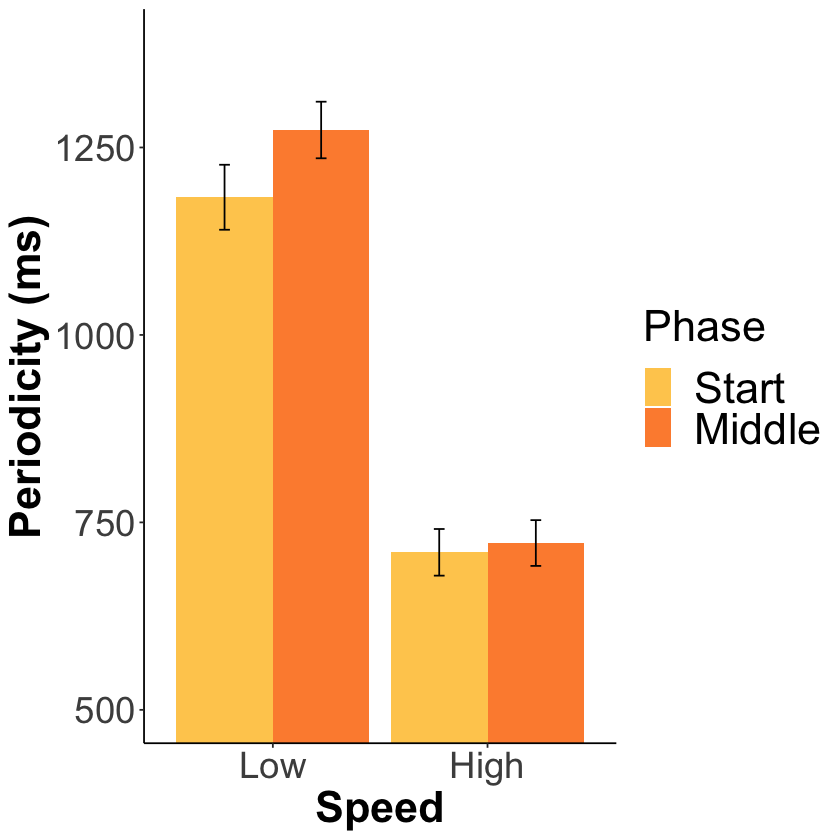

In [12]:
#A) Final Periodicity - Plot No Transfer
ToPlot_NoTransfer_Per <- ToPlot_Per %>% filter(!Phase=='MidT') %>% filter(!Phase=='StartT')
datac_Per1 <- summarySE(ToPlot_NoTransfer_Per, measurevar="Periodicity", groupvars=c("Speed","Phase"))
my_yellow = c(brewer.pal(n = 5, "YlOrRd")[2:3])

meansPer1 <- ggplot(datac_Per1, aes(x=Speed, y=Periodicity, fill=Phase)) + 
     geom_bar(stat="identity", position=position_dodge()) +
     geom_errorbar(aes(ymin=Periodicity-se, ymax=Periodicity+se), width =0.1, position=position_dodge(.9), color="black") +
     labs(x = "Speed", y = "Periodicity (ms)") + theme_classic() +
#     scale_fill_brewer(palette="YlOrRd") + 
     scale_fill_manual(values=my_yellow,labels=c('Start','Middle')) +
     scale_x_discrete(labels=c("Low","High")) +
#     geom_signif(y_position=c(900,1250,1250), xmin=c(0.8, 1.8), xmax=c(1.2, 2.2),
#              annotation=c("NS", "NS","NS"), tip_length=0.01,textsize=6) +
#     geom_signif(comparisons=list(c("Slow", "Medium")), annotations="***",
#              y_position = 1350, tip_length = 0.02, vjust=0.4,textsize=7) +
     theme(plot.title = element_text(size=18,hjust=0.5),
     axis.text = element_text(size = 22),
     strip.text = element_text(size = 20,face = "bold"),
     axis.title = element_text( size = 26, face = "bold" ),
     legend.title=element_text(size=26),
     legend.text=element_text(size=26)) +
     coord_cartesian(ylim = c(500,1390)) 
#     ggtitle("Human Periodicity across speeds")
meansPer1

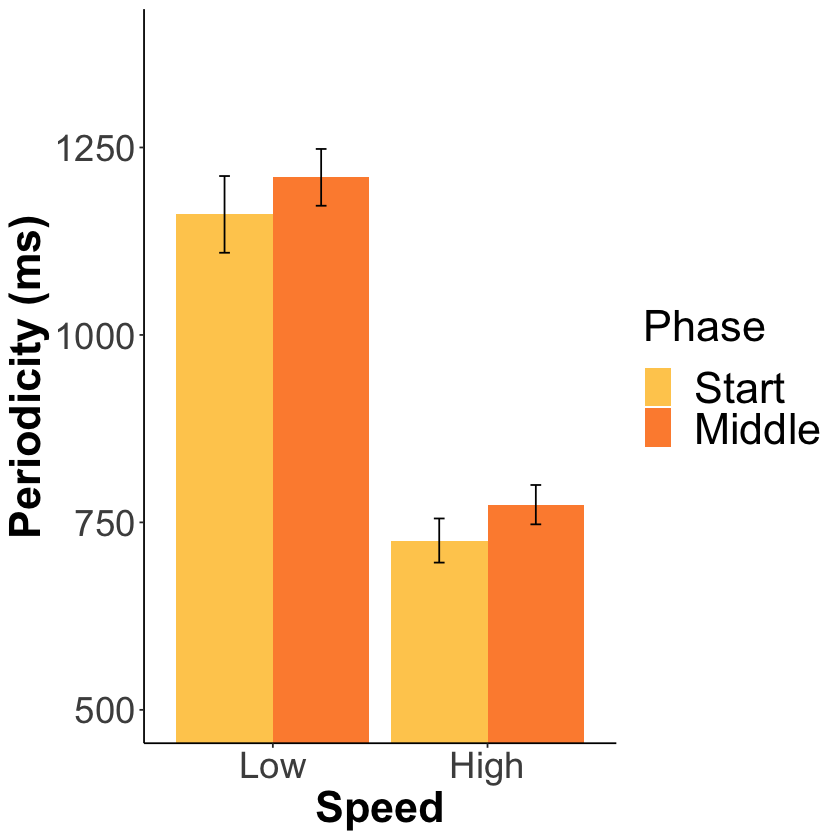

In [13]:
#B) Final Periodicity - Plot Transfer
ToPlot_Transfer_Per <- ToPlot_Per %>% filter(!Phase=='MidNoT') %>% filter(!Phase=='StartNoT')
datac_Per2 <- summarySE(ToPlot_Transfer_Per, measurevar="Periodicity", groupvars=c("Speed","Phase"))
my_yellow = c(brewer.pal(n = 5, "YlOrRd")[2:3])

meansPer2 <- ggplot(datac_Per2, aes(x=Speed, y=Periodicity, fill=Phase)) + 
     geom_bar(stat="identity", position=position_dodge()) +
     geom_errorbar(aes(ymin=Periodicity-se, ymax=Periodicity+se), width =0.1, position=position_dodge(.9), color="black") +
     labs(x = "Speed", y = "Periodicity (ms)") + theme_classic() +
     scale_fill_manual(values=my_yellow,labels=c('Start','Middle')) +
     scale_x_discrete(labels=c("Low","High")) +
#     geom_signif(y_position=c(900,1250,1250), xmin=c(0.8, 1.8), xmax=c(1.2, 2.2),
#              annotation=c("NS", "NS","NS"), tip_length=0.01,textsize=6) +
#     geom_signif(comparisons=list(c("Slow", "Medium")), annotations="***",
#              y_position = 1350, tip_length = 0.02, vjust=0.4,textsize=7) +
     theme(plot.title = element_text(size=18,hjust=0.5),
     axis.text = element_text(size = 22),
     strip.text = element_text(size = 20,face = "bold"),
     axis.title = element_text( size = 26, face = "bold" ),
     legend.title=element_text(size=26),
     legend.text=element_text(size=26)) +
     coord_cartesian(ylim = c(500,1390)) 
#     ggtitle("Human Periodicity across speeds")
meansPer2

# Entropy

In [14]:
Hum_StMed <- Start_Medium$Entropy
Ag_StMed <- Start_Medium$Subject
n1<-length(Hum_StMed)
n1
Hum_StSlow <- Start_Slow$Entropy
Ag_StSlow <- Start_Slow$Subject
n2<-length(Hum_StSlow)
n2
Hum_StMedT <- Start_MediumT$Entropy
Ag_StMedT <- Start_MediumT$Subject
n1b<-length(Hum_StMedT)
n1b
Hum_StSlowT <- Start_SlowT$Entropy
Ag_StSlowT <- Start_SlowT$Subject
n2b<-length(Hum_StSlowT)
n2b
Hum_MidMed <- Mid_SMS$Entropy
Ag_MidMed <- Mid_SMS$Subject
n3<-length(Hum_MidMed)
n3
Hum_MidSlow <- Mid_MSM$Entropy
Ag_MidSlow <- Mid_MSM$Subject
n4<-length(Hum_MidSlow)
n4
Hum_MidPureM <- Mid_MMM$Entropy
Ag_MidPureM <- Mid_MMM$Subject
n5<-length(Hum_MidPureM)
n5
Hum_MidPureS <- Mid_SSS$Entropy
Ag_MidPureS <- Mid_SSS$Subject
n6<-length(Hum_MidPureS)
n6
n_Total<-n1+n2+n1b+n2b+n3+n4+n5+n6
n_Total

[1] 18

[1] 19

[1] 20

[1] 19

[1] 19

[1] 20

[1] 18

[1] 19

[1] 152

In [15]:
Speed <- c(rep("Medium",n1b),rep("Slow",n2b),rep("Medium",n1),rep("Slow",n2),rep("Medium",n3),rep("Slow",n4),rep("Medium",n5),rep("Slow",n6))
Subject <- c(Ag_StMedT,Ag_StSlowT,Ag_StMed,Ag_StSlow,Ag_MidMed,Ag_MidSlow,Ag_MidPureM,Ag_MidPureS)
Entropy <- c(Hum_StMedT,Hum_StSlowT,Hum_StMed,Hum_StSlow,Hum_MidMed,Hum_MidSlow,Hum_MidPureM,Hum_MidPureS)
Phase <- c(rep("StartT",n1b),rep("StartT",n2b),rep("StartNoT",n1),rep("StartNoT",n2),rep("MidT",n3),rep("MidT",n4),rep("MidNoT",n5),rep("MidNoT",n6))
length(Speed)
ToPlot_Ent <- data.frame(Subject,Speed,Phase,Entropy)
ToPlot_Ent$Speed <- ordered(ToPlot_Ent$Speed, levels = c("Slow", "Medium"))
ToPlot_Ent$Phase <- ordered(ToPlot_Ent$Phase, levels = c("StartT", "StartNoT","MidT","MidNoT"))
head(ToPlot_Ent)

[1] 152

,Subject,Speed,Phase,Entropy
,<fct>,<ord>,<ord>,<dbl>
1,A10GBO6PU2EI0K,Medium,StartT,3.246518
2,A16335MOISDG1F,Medium,StartT,3.172987
3,A1E8ZYOQSGKTP8,Medium,StartT,3.398248
4,A1YSBD5XW5UCR0,Medium,StartT,2.865347
5,A2E609OEGN4D6H,Medium,StartT,3.584057
6,A2GO3SYV3X3KE,Medium,StartT,3.345698


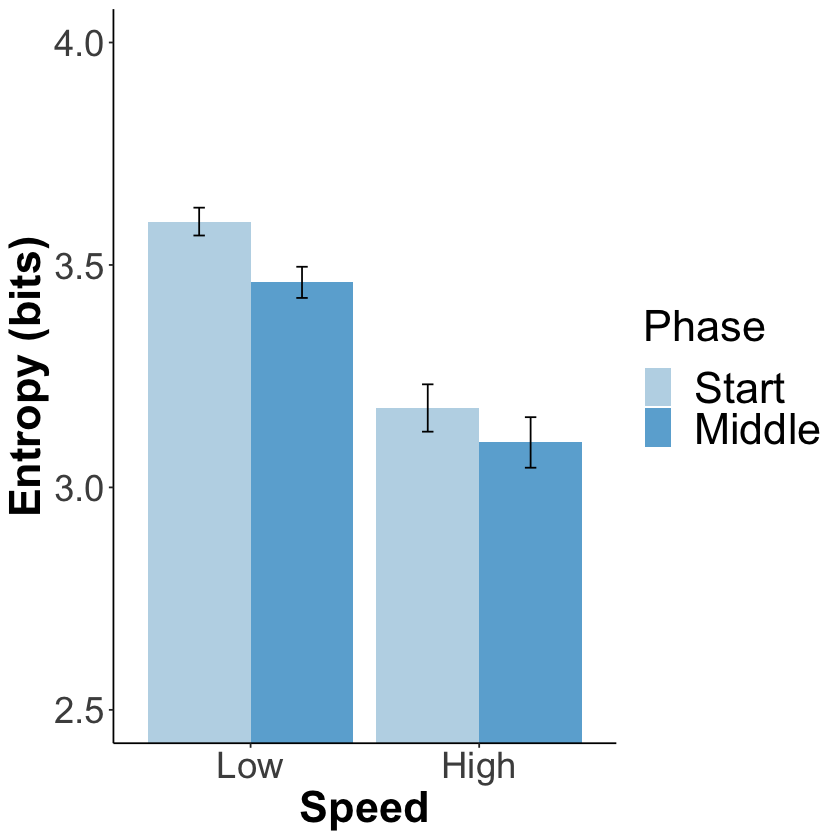

In [16]:
#Final Entropy
#A/ case Start & No Transfer
Ent_data1 <- ToPlot_Ent %>% filter(!Phase=='MidT') %>% filter(!Phase=='StartT')
datac_Ent1 <- summarySE(Ent_data1, measurevar="Entropy", groupvars=c("Speed","Phase"))
my_blue = c(brewer.pal(n = 5, "Blues")[2:3])

meansEnt1 <- ggplot(datac_Ent1, aes(x=Speed, y=Entropy, fill=Phase)) + 
     geom_bar(stat="identity", position=position_dodge()) +
     geom_errorbar(aes(ymin=Entropy-se, ymax=Entropy+se), width =0.1, position=position_dodge(.9), color="black") +
     labs(x = "Speed", y = "Entropy (bits)") + theme_classic() +
     scale_fill_manual(values=my_blue,labels=c('Start','Middle')) +
     scale_x_discrete(labels=c("Low","High")) +
#     geom_signif(stat="identity",aes(x=c(1.75),xend=c(2.25), y=c(3.68), yend=c(3.68),annotation=c("*"),textsize=6,vjust=0.4)) +
#     geom_signif(stat="identity",aes(x=c(2),xend=c(2.25), y=c(3.6), yend=c(3.6),annotation=c("***"),textsize=6,vjust=0.4)) +
#     stat_compare_means(label = "p.signif", method="wilcox.test", hide.ns=TRUE, paired=FALSE)+
#     geom_signif(comparisons=list(c("Slow", "Medium")), annotations="***",
#              y_position = 3.8, tip_length = 0.02, vjust=0.4,textsize=7) +
     theme(plot.title = element_text(size=18,hjust=0.5),
     axis.text = element_text(size = 22),
     strip.text = element_text(size = 20,face = "bold"),
     axis.title = element_text( size = 26, face = "bold" ),
     legend.title=element_text(size=26),
     legend.text=element_text(size=26)) +
     coord_cartesian(ylim = c(2.5,4)) 
#     ggtitle("Human Entropy across speeds")
meansEnt1

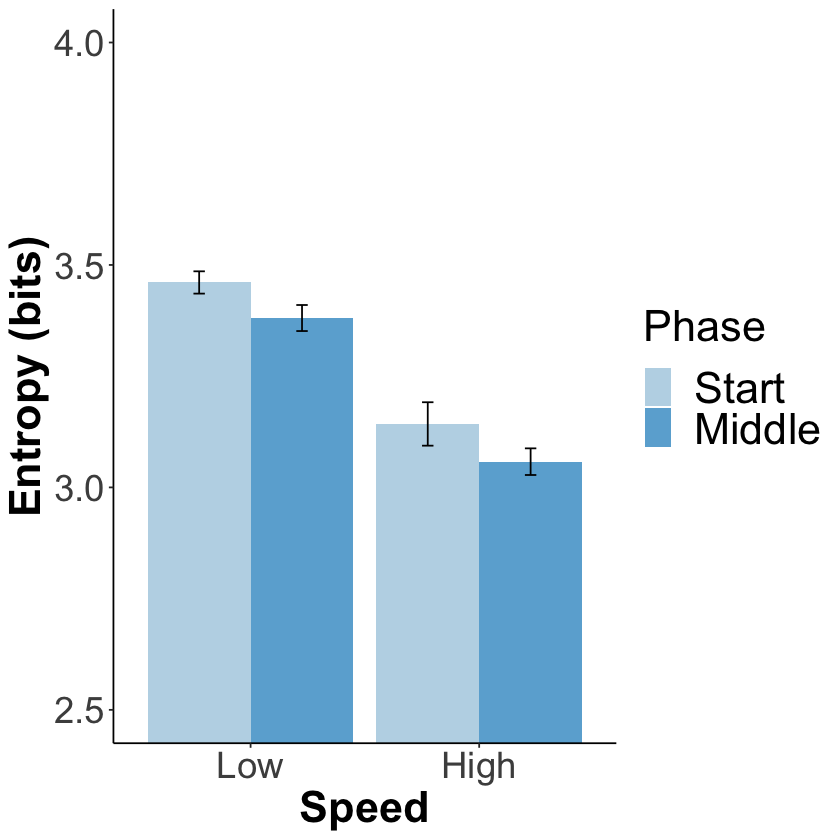

In [17]:
#B/ case Start & Transfer
Ent_data2 <- ToPlot_Ent %>% filter(!Phase=='MidNoT') %>% filter(!Phase=='StartNoT')
datac_Ent2 <- summarySE(Ent_data2, measurevar="Entropy", groupvars=c("Speed","Phase"))

meansEnt2 <- ggplot(datac_Ent2, aes(x=Speed, y=Entropy, fill=Phase)) + 
     geom_bar(stat="identity", position=position_dodge()) +
     geom_errorbar(aes(ymin=Entropy-se, ymax=Entropy+se), width =0.1, position=position_dodge(.9), color="black") +
     labs(x = "Speed", y = "Entropy (bits)") + theme_classic() +
     scale_fill_manual(values=my_blue,labels=c('Start','Middle')) +
     scale_x_discrete(labels=c("Low","High")) +
#     geom_signif(stat="identity",aes(x=c(1.75),xend=c(2.25), y=c(3.68), yend=c(3.68),annotation=c("*"),textsize=6,vjust=0.4)) +
#     geom_signif(stat="identity",aes(x=c(2),xend=c(2.25), y=c(3.6), yend=c(3.6),annotation=c("***"),textsize=6,vjust=0.4)) +
#     stat_compare_means(label = "p.signif", method="wilcox.test", hide.ns=TRUE, paired=FALSE)+
#     geom_signif(comparisons=list(c("Slow", "Medium")), annotations="***",
#              y_position = 3.8, tip_length = 0.02, vjust=0.4,textsize=7) +
     theme(plot.title = element_text(size=18,hjust=0.5),
     axis.text = element_text(size = 22),
     strip.text = element_text(size = 20,face = "bold"),
     axis.title = element_text( size = 26, face = "bold" ),
     legend.title=element_text(size=26),
     legend.text=element_text(size=26)) +
     coord_cartesian(ylim = c(2.5,4)) 
#     ggtitle("Human Entropy across speeds")
meansEnt2

# Log CV ISI

In [18]:
Hum_StMed <- Start_Medium$lCV
Ag_StMed <- Start_Medium$Subject
n1<-length(Hum_StMed)
n1
Hum_StSlow <- Start_Slow$lCV
Ag_StSlow <- Start_Slow$Subject
n2<-length(Hum_StSlow)
n2
Hum_StMedT <- Start_MediumT$lCV
Ag_StMedT <- Start_MediumT$Subject
n1b<-length(Hum_StMedT)
n1b
Hum_StSlowT <- Start_SlowT$lCV
Ag_StSlowT <- Start_SlowT$Subject
n2b<-length(Hum_StSlowT)
n2b
Hum_MidMed <- Mid_SMS$lCV
Ag_MidMed <- Mid_SMS$Subject
n3<-length(Hum_MidMed)
n3
Hum_MidSlow <- Mid_MSM$lCV
Ag_MidSlow <- Mid_MSM$Subject
n4<-length(Hum_MidSlow)
n4
Hum_MidPureM <- Mid_MMM$lCV
Ag_MidPureM <- Mid_MMM$Subject
n5<-length(Hum_MidPureM)
n5
Hum_MidPureS <- Mid_SSS$lCV
Ag_MidPureS <- Mid_SSS$Subject
n6<-length(Hum_MidPureS)
n6
n_Total<-n1+n2+n1b+n2b+n3+n4+n5+n6
n_Total

[1] 18

[1] 19

[1] 20

[1] 19

[1] 19

[1] 20

[1] 18

[1] 19

[1] 152

In [19]:
Speed <- c(rep("Medium",n1b),rep("Slow",n2b),rep("Medium",n1),rep("Slow",n2),rep("Medium",n3),rep("Slow",n4),rep("Medium",n5),rep("Slow",n6))
Subject <- c(Ag_StMedT,Ag_StSlowT,Ag_StMed,Ag_StSlow,Ag_MidMed,Ag_MidSlow,Ag_MidPureM,Ag_MidPureS)
lCV <- c(Hum_StMedT,Hum_StSlowT,Hum_StMed,Hum_StSlow,Hum_MidMed,Hum_MidSlow,Hum_MidPureM,Hum_MidPureS)
Phase <- c(rep("StartT",n1b),rep("StartT",n2b),rep("StartNoT",n1),rep("StartNoT",n2),rep("MidT",n3),rep("MidT",n4),rep("MidNoT",n5),rep("MidNoT",n6))
length(Speed)
ToPlot_lcv <- data.frame(Subject,Speed,Phase,lCV)
ToPlot_lcv$Speed <- ordered(ToPlot_lcv$Speed, levels = c("Slow", "Medium"))
ToPlot_lcv$Phase <- ordered(ToPlot_lcv$Phase, levels = c("StartT", "StartNoT","MidT","MidNoT"))
head(ToPlot_lcv)

[1] 152

,Subject,Speed,Phase,lCV
,<fct>,<ord>,<ord>,<dbl>
1,A10GBO6PU2EI0K,Medium,StartT,-1.2202040
2,A16335MOISDG1F,Medium,StartT,-0.9372757
3,A1E8ZYOQSGKTP8,Medium,StartT,-0.2857093
4,A1YSBD5XW5UCR0,Medium,StartT,-1.4761271
5,A2E609OEGN4D6H,Medium,StartT,-0.4980249
6,A2GO3SYV3X3KE,Medium,StartT,-0.8536570


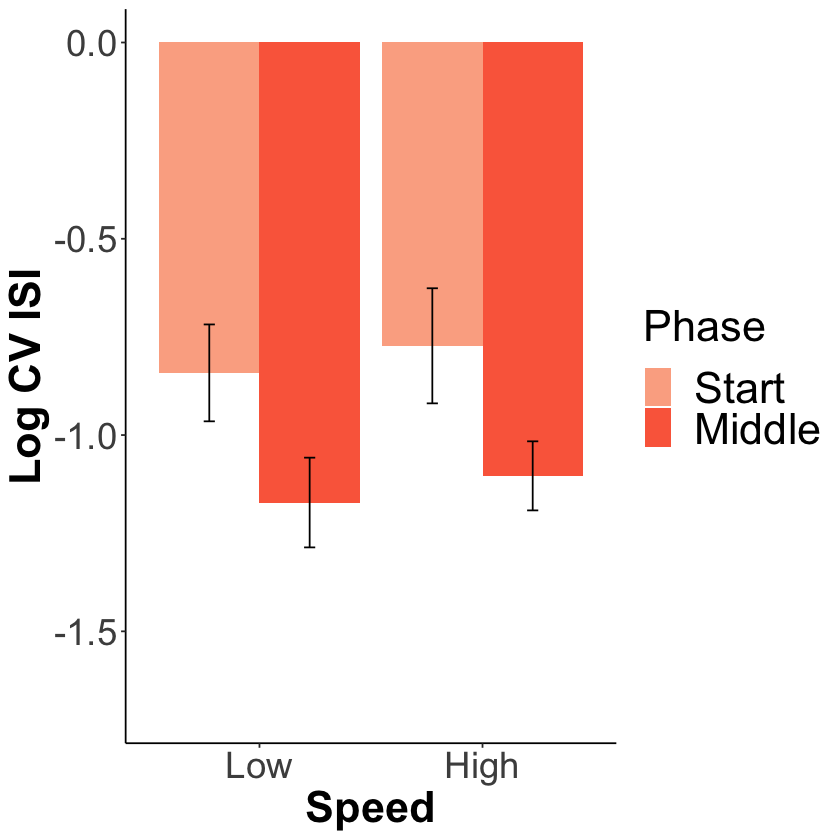

In [20]:
#A/ case Start & No Transfer
lCV_data1 <- ToPlot_lcv %>% filter(!Phase=='MidT') %>% filter(!Phase=='StartT')
datac_lcv1 <- summarySE(lCV_data1, measurevar="lCV", groupvars=c("Speed","Phase"))
my_red = c(brewer.pal(n = 5, "Reds")[2:3])

meanslcv1 <- ggplot(datac_lcv1, aes(x=Speed, y=lCV, fill=Phase)) + 
     geom_bar(stat="identity", position=position_dodge()) +
     geom_errorbar(aes(ymin=lCV-se, ymax=lCV+se), width =0.1, position=position_dodge(.9), color="black") +
     labs(x = "Speed", y = "Log CV ISI") + theme_classic() +
     scale_fill_manual(values=my_red,labels=c('Start','Middle')) +
     scale_x_discrete(labels=c("Low","High")) +
#     geom_signif(y_position=c(-1.5,-1.5), xmin=c(0.8, 1.8), xmax=c(1.2, 2.2),
#              annotation=c("***", "***"), tip_length=-0.01,textsize=7) +
#     stat_compare_means(aes(group=Phase), label = "p.signif", method="wilcox.test", hide.ns=T, paired=F) +
#     geom_signif(stat="identity",aes(x=c(1),xend=c(1.25), y=c(-1.5), yend=c(-1.5),annotation=c("***"),textsize=6,vjust=1.9)) +
#     geom_signif(stat="identity",aes(x=c(2),xend=c(2.25), y=c(-1.385), yend=c(-1.385),annotation=c("***"),textsize=6,vjust=1.9)) +
#     geom_signif(stat="identity",aes(x=c(0.75),xend=c(1), y=c(-1.385), yend=c(-1.385),annotation=c("*"),textsize=6,vjust=1.9)) +
#     geom_signif(stat="identity",aes(x=c(1.75),xend=c(2.25), y=c(-1.5), yend=c(-1.5),annotation=c("*"),textsize=6,vjust=1.9)) +     
#     geom_signif(comparisons=list(c("Slow", "Medium")), annotations="NS",
#              y_position = -1.65, tip_length = -0.02, vjust=1.9,textsize=5) +
     theme(plot.title = element_text(size=18,hjust=0.5),
     axis.text = element_text(size = 22),
     strip.text = element_text(size = 20,face = "bold"),
     axis.title = element_text( size = 26, face = "bold" ),
     legend.title=element_text(size=26),
     legend.text=element_text(size=26)) +
     coord_cartesian(ylim = c(-1.7,0)) 
#     ggtitle("Human timing variability across speeds")
meanslcv1

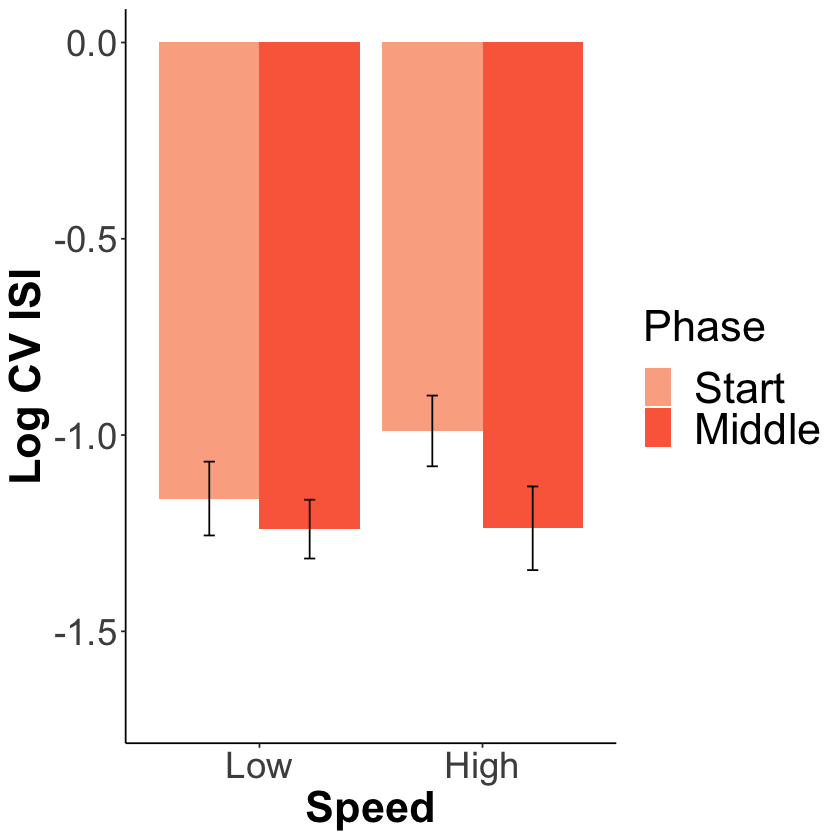

In [21]:
#B/ case Start & Transfer
lCV_data2 <- ToPlot_lcv %>% filter(!Phase=='MidNoT') %>% filter(!Phase=='StartNoT')
datac_lcv2 <- summarySE(lCV_data2, measurevar="lCV", groupvars=c("Speed","Phase"))

meanslcv2 <- ggplot(datac_lcv2, aes(x=Speed, y=lCV, fill=Phase)) + 
     geom_bar(stat="identity", position=position_dodge()) +
     geom_errorbar(aes(ymin=lCV-se, ymax=lCV+se), width =0.1, position=position_dodge(.9), color="black") +
     labs(x = "Speed", y = "Log CV ISI") + theme_classic() +
     scale_fill_manual(values=my_red,labels=c('Start','Middle')) +
     scale_x_discrete(labels=c("Low","High")) +
#     geom_signif(y_position=c(-1.5,-1.5), xmin=c(0.8, 1.8), xmax=c(1.2, 2.2),
#              annotation=c("***", "***"), tip_length=-0.01,textsize=7) +
#     stat_compare_means(aes(group=Phase), label = "p.signif", method="wilcox.test", hide.ns=T, paired=F) +
#     geom_signif(stat="identity",aes(x=c(1),xend=c(1.25), y=c(-1.5), yend=c(-1.5),annotation=c("***"),textsize=6,vjust=1.9)) +
#     geom_signif(stat="identity",aes(x=c(2),xend=c(2.25), y=c(-1.385), yend=c(-1.385),annotation=c("***"),textsize=6,vjust=1.9)) +
#     geom_signif(stat="identity",aes(x=c(0.75),xend=c(1), y=c(-1.385), yend=c(-1.385),annotation=c("*"),textsize=6,vjust=1.9)) +
#     geom_signif(stat="identity",aes(x=c(1.75),xend=c(2.25), y=c(-1.5), yend=c(-1.5),annotation=c("*"),textsize=6,vjust=1.9)) +     
#     geom_signif(comparisons=list(c("Slow", "Medium")), annotations="NS",
#              y_position = -1.65, tip_length = -0.02, vjust=1.9,textsize=5) +
     theme(plot.title = element_text(size=18,hjust=0.5),
     axis.text = element_text(size = 22),
     strip.text = element_text(size = 20,face = "bold"),
     axis.title = element_text( size = 26, face = "bold" ),
     legend.title=element_text(size=26),
     legend.text=element_text(size=26)) +
     coord_cartesian(ylim = c(-1.7,0)) 
#     ggtitle("Human timing variability across speeds")
meanslcv2

# Regularity

In [22]:
Hum_StMed <- Start_Medium$Amplitude
Ag_StMed <- Start_Medium$Subject
n1<-length(Hum_StMed)
n1
Hum_StSlow <- Start_Slow$Amplitude
Ag_StSlow <- Start_Slow$Subject
n2<-length(Hum_StSlow)
n2
Hum_StMedT <- Start_MediumT$Amplitude
Ag_StMedT <- Start_MediumT$Subject
n1b<-length(Hum_StMedT)
n1b
Hum_StSlowT <- Start_SlowT$Amplitude
Ag_StSlowT <- Start_SlowT$Subject
n2b<-length(Hum_StSlowT)
n2b
Hum_MidMed <- Mid_SMS$Amplitude
Ag_MidMed <- Mid_SMS$Subject
n3<-length(Hum_MidMed)
n3
Hum_MidSlow <- Mid_MSM$Amplitude
Ag_MidSlow <- Mid_MSM$Subject
n4<-length(Hum_MidSlow)
n4
Hum_MidPureM <- Mid_MMM$Amplitude
Ag_MidPureM <- Mid_MMM$Subject
n5<-length(Hum_MidPureM)
n5
Hum_MidPureS <- Mid_SSS$Amplitude
Ag_MidPureS <- Mid_SSS$Subject
n6<-length(Hum_MidPureS)
n6
n_Total<-n1+n2+n1b+n2b+n3+n4+n5+n6
n_Total

[1] 18

[1] 19

[1] 20

[1] 19

[1] 19

[1] 20

[1] 18

[1] 19

[1] 152

In [23]:
Speed <- c(rep("Medium",n1b),rep("Slow",n2b),rep("Medium",n1),rep("Slow",n2),rep("Medium",n3),rep("Slow",n4),rep("Medium",n5),rep("Slow",n6))
Subject <- c(Ag_StMedT,Ag_StSlowT,Ag_StMed,Ag_StSlow,Ag_MidMed,Ag_MidSlow,Ag_MidPureM,Ag_MidPureS)
Regularity <- c(Hum_StMedT,Hum_StSlowT,Hum_StMed,Hum_StSlow,Hum_MidMed,Hum_MidSlow,Hum_MidPureM,Hum_MidPureS)
Phase <- c(rep("StartT",n1b),rep("StartT",n2b),rep("StartNoT",n1),rep("StartNoT",n2),rep("MidT",n3),rep("MidT",n4),rep("MidNoT",n5),rep("MidNoT",n6))
length(Speed)
ToPlot_reg <- data.frame(Subject,Speed,Phase,Regularity)
ToPlot_reg$Speed <- ordered(ToPlot_reg$Speed, levels = c("Slow", "Medium"))
ToPlot_reg$Phase <- ordered(ToPlot_reg$Phase, levels = c("StartT", "StartNoT","MidT","MidNoT"))
head(ToPlot_reg)

[1] 152

,Subject,Speed,Phase,Regularity
,<fct>,<ord>,<ord>,<dbl>
1,A10GBO6PU2EI0K,Medium,StartT,0.1915128
2,A16335MOISDG1F,Medium,StartT,0.1426969
3,A1E8ZYOQSGKTP8,Medium,StartT,0.3854300
4,A1YSBD5XW5UCR0,Medium,StartT,0.4248110
5,A2E609OEGN4D6H,Medium,StartT,0.2559327
6,A2GO3SYV3X3KE,Medium,StartT,0.3034830


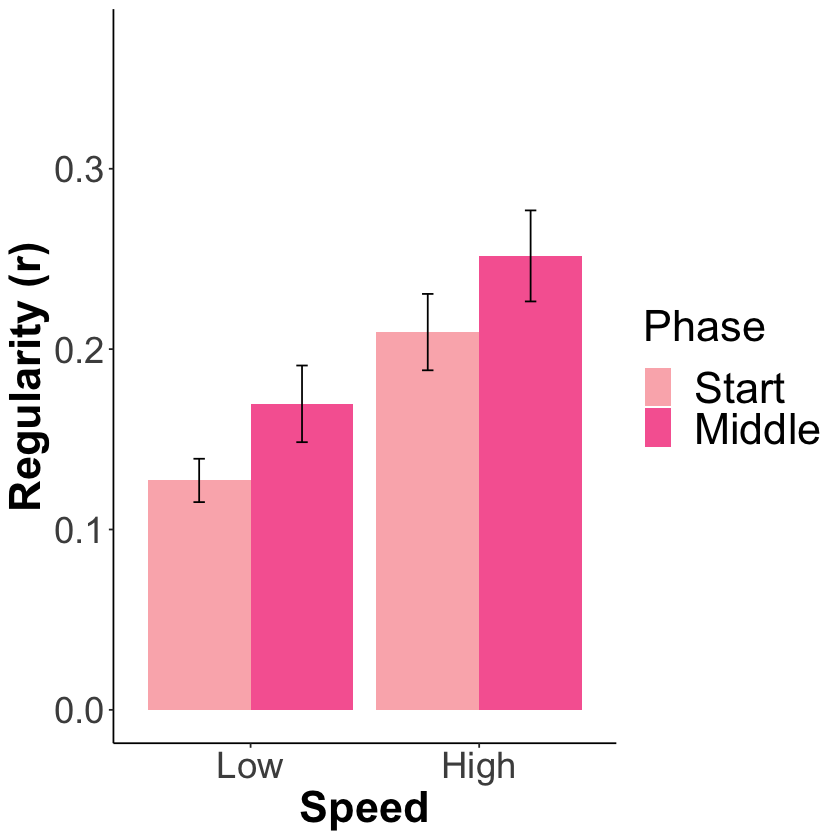

In [24]:
#A/ case Start & No Transfer
Reg_data1 <- ToPlot_reg %>% filter(!Phase=='MidT') %>% filter(!Phase=='StartT')
datac_reg1 <- summarySE(Reg_data1, measurevar="Regularity", groupvars=c("Speed","Phase"))
my_purple = c(brewer.pal(n = 5, "RdPu")[2:3])

meansReg1 <- ggplot(datac_reg1, aes(x=Speed, y=Regularity, fill=Phase)) + 
     geom_bar(stat="identity", position=position_dodge()) +
     geom_errorbar(aes(ymin=Regularity-se, ymax=Regularity+se), width =0.1, position=position_dodge(.9), color="black") +
     labs(x = "Speed", y = "Regularity (r)") + theme_classic() +
     scale_fill_manual(values=my_purple,labels=c('Start','Middle')) +
     scale_x_discrete(labels=c("Low","High")) +
#     geom_signif(y_position=c(-1.5,-1.5), xmin=c(0.8, 1.8), xmax=c(1.2, 2.2),
#              annotation=c("***", "***"), tip_length=-0.01,textsize=7) +
#     geom_bracket(xmin = 0.5, xmax=1.5, y.position = 0.475, label = "*",tip.length = 0.01) +
#     geom_signif(stat="identity",aes(x=c(1),xend=c(1.25), y=c(0.31), yend=c(0.31),annotation=c("*"),textsize=6,vjust=0.4)) +
#    geom_signif(comparisons=list(c("Slow", "Medium")), annotations="***",
#              y_position = 0.35, tip_length = 0.02, vjust=0.4,textsize=7) +
     theme(plot.title = element_text(size=18,hjust=0.5),
     axis.text = element_text(size = 22),
     strip.text = element_text(size = 20,face = "bold"),
     axis.title = element_text( size = 26, face = "bold" ),
     legend.title=element_text(size=26),
     legend.text=element_text(size=26)) +
     coord_cartesian(ylim = c(0,0.37)) 
#     ggtitle("Human regularity across speeds")
meansReg1

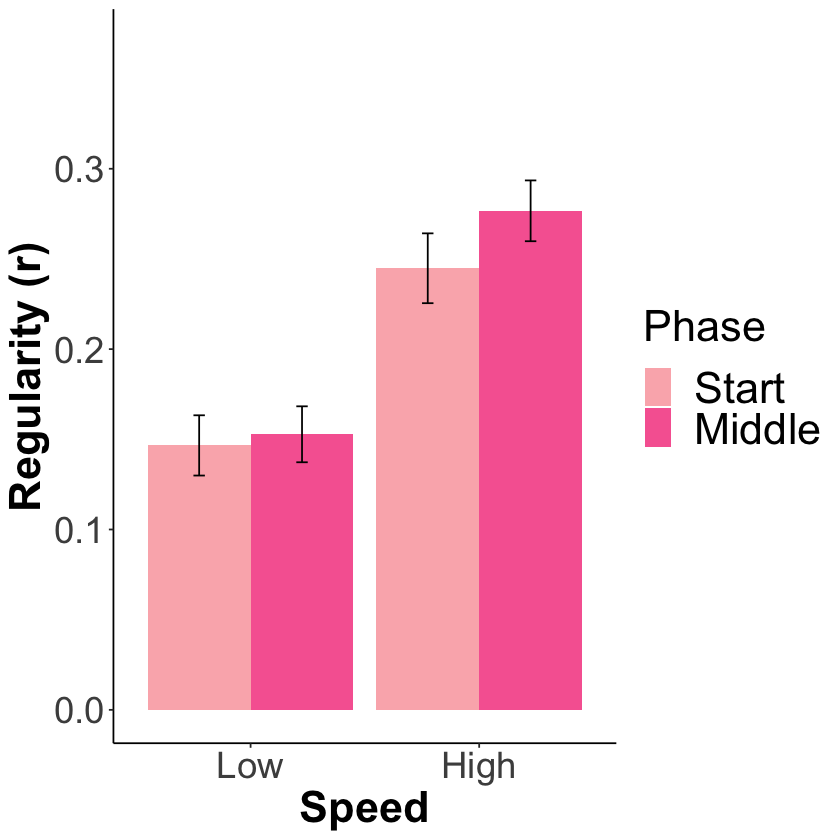

In [25]:
#B/ case Start & Transfer
Reg_data2 <- ToPlot_reg %>% filter(!Phase=='MidNoT') %>% filter(!Phase=='StartNoT')
datac_reg2 <- summarySE(Reg_data2, measurevar="Regularity", groupvars=c("Speed","Phase"))

meansReg2 <- ggplot(datac_reg2, aes(x=Speed, y=Regularity, fill=Phase)) + 
     geom_bar(stat="identity", position=position_dodge()) +
     geom_errorbar(aes(ymin=Regularity-se, ymax=Regularity+se), width =0.1, position=position_dodge(.9), color="black") +
     labs(x = "Speed", y = "Regularity (r)") + theme_classic() +
     scale_fill_manual(values=my_purple,labels=c('Start','Middle')) +
     scale_x_discrete(labels=c("Low","High")) +
#     geom_signif(y_position=c(-1.5,-1.5), xmin=c(0.8, 1.8), xmax=c(1.2, 2.2),
#              annotation=c("***", "***"), tip_length=-0.01,textsize=7) +
#     geom_bracket(xmin = 0.5, xmax=1.5, y.position = 0.475, label = "*",tip.length = 0.01) +
#     geom_signif(stat="identity",aes(x=c(1),xend=c(1.25), y=c(0.31), yend=c(0.31),annotation=c("*"),textsize=6,vjust=0.4)) +
#    geom_signif(comparisons=list(c("Slow", "Medium")), annotations="***",
#              y_position = 0.35, tip_length = 0.02, vjust=0.4,textsize=7) +
     theme(plot.title = element_text(size=18,hjust=0.5),
     axis.text = element_text(size = 22),
     strip.text = element_text(size = 20,face = "bold"),
     axis.title = element_text( size = 26, face = "bold" ),
     legend.title=element_text(size=26),
     legend.text=element_text(size=26)) +
     coord_cartesian(ylim = c(0,0.37)) 
#     ggtitle("Human regularity across speeds")
meansReg2

In [26]:
toSave1 <- ggarrange(meansEnt2,meansPer2,meanslcv2,meansReg2, ncol=2, nrow=2, legend="right")
toSave1 <- annotate_figure(toSave1,top = text_grob("Transfer comparisons", color = "black", face = "bold", size = 36))
ggsave("../Figures/Phase_Compare_Humans_Transfer.png",toSave1,width=18,height=13)

In [27]:
toSave2 <- ggarrange(meansEnt1,meansPer1,meanslcv1,meansReg1, ncol=2, nrow=2, legend="right")
toSave2 <- annotate_figure(toSave2,top = text_grob("No Transfer comparisons", color = "black", face = "bold", size = 36))
ggsave("../Figures/Phase_Compare_Humans_NoTransfer.png",toSave2,width=18,height=13)

In [28]:
ggsave("../Figures/Phase_Compare_Humans_ALL.png",multiplot(toSave1,toSave2, cols=2),width=36,height=13)